In [42]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from utils import read_log
from math import log, sqrt
from statistics import NormalDist

In [43]:
class BlackScholes:
    @staticmethod
    def call_price(spot, strike, time_to_expiry, volatility):
        d1 = (
            log(spot) - log(strike) + (0.5 * volatility * volatility) * time_to_expiry
        ) / (volatility * sqrt(time_to_expiry))
        d2 = d1 - volatility * sqrt(time_to_expiry)
        call_price = spot * NormalDist().cdf(d1) - strike * NormalDist().cdf(d2)
        return call_price

    @staticmethod
    def delta(spot, strike, time_to_expiry, volatility):
        d1 = (
            log(spot) - log(strike) + (0.5 * volatility * volatility) * time_to_expiry
        ) / (volatility * sqrt(time_to_expiry))
        return NormalDist().cdf(d1)

    @staticmethod
    def implied_volatility(
        call_price, spot, strike, time_to_expiry, max_iterations=200, tolerance=1e-10
    ):
        low_vol = 0.01
        high_vol = 1.0
        volatility = (low_vol + high_vol) / 2.0  # Initial guess as the midpoint
        for _ in range(max_iterations):
            estimated_price = BlackScholes.call_price(
                spot, strike, time_to_expiry, volatility
            )
            diff = estimated_price - call_price
            if abs(diff) < tolerance:
                break
            elif diff > 0:
                high_vol = volatility
            else:
                low_vol = volatility
            volatility = (low_vol + high_vol) / 2.0
        return volatility

# Round 3

In [2]:
price_0 = pd.read_csv('../data/raw/round_3/prices_round_3_day_0.csv', delimiter=';')
price_1 = pd.read_csv('../data/raw/round_3/prices_round_3_day_1.csv', delimiter=';')
price_2 = pd.read_csv('../data/raw/round_3/prices_round_3_day_2.csv', delimiter=';')

In [3]:
trades_0 = pd.read_csv('../data/raw/round_3/trades_round_3_day_0.csv', delimiter=';')
trades_1 = pd.read_csv('../data/raw/round_3/trades_round_3_day_1.csv', delimiter=';')
trades_2 = pd.read_csv('../data/raw/round_3/trades_round_3_day_2.csv', delimiter=';')

In [4]:
prices = pd.concat([price_0, price_1, price_2], axis=0).reset_index(drop=True)
trades = pd.concat([trades_0, trades_1, trades_2], axis=0).reset_index(drop=True)

In [9]:
prices['product'].unique()

array(['VOLCANIC_ROCK_VOUCHER_10500', 'DJEMBES', 'CROISSANTS', 'JAMS',
       'VOLCANIC_ROCK_VOUCHER_10000', 'KELP',
       'VOLCANIC_ROCK_VOUCHER_9750', 'PICNIC_BASKET1', 'PICNIC_BASKET2',
       'VOLCANIC_ROCK_VOUCHER_9500', 'RAINFOREST_RESIN',
       'VOLCANIC_ROCK_VOUCHER_10250', 'SQUID_INK', 'VOLCANIC_ROCK'],
      dtype=object)

In [10]:
rock = prices[prices['product'] == 'VOLCANIC_ROCK'].reset_index(drop=True)
call_0 = prices[prices['product'] == 'VOLCANIC_ROCK_VOUCHER_9500'].reset_index(drop=True)
call_1 = prices[prices['product'] == 'VOLCANIC_ROCK_VOUCHER_9750'].reset_index(drop=True)
call_2 = prices[prices['product'] == 'VOLCANIC_ROCK_VOUCHER_10000'].reset_index(drop=True)
call_3 = prices[prices['product'] == 'VOLCANIC_ROCK_VOUCHER_10250'].reset_index(drop=True)
call_4 = prices[prices['product'] == 'VOLCANIC_ROCK_VOUCHER_10500'].reset_index(drop=True)

In [17]:
products = [rock, call_0, call_1, call_2, call_3, call_4]

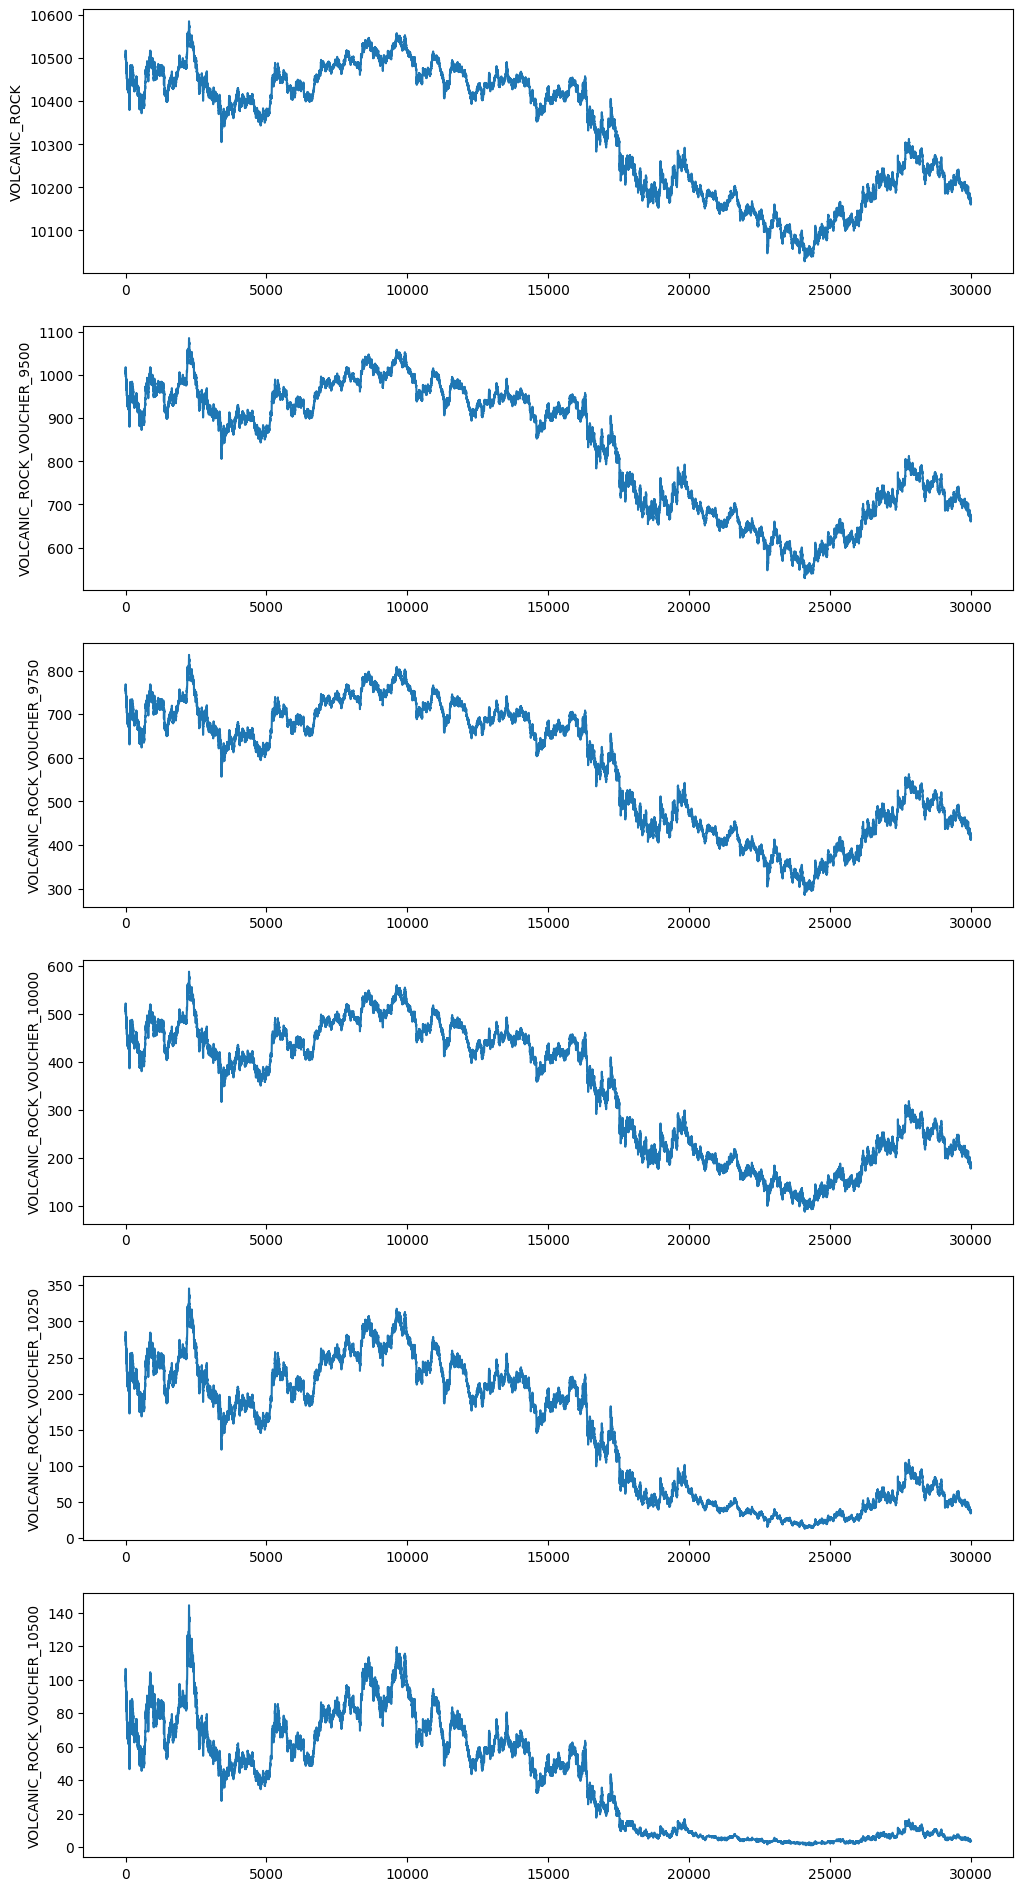

In [21]:
fig, ax = plt.subplots(6, 1, figsize=(12, 24))
for i, prod in enumerate(products):
    ax[i].plot(prod['mid_price'])
    ax[i].set_ylabel(prod['product'].iloc[0])
plt.show()

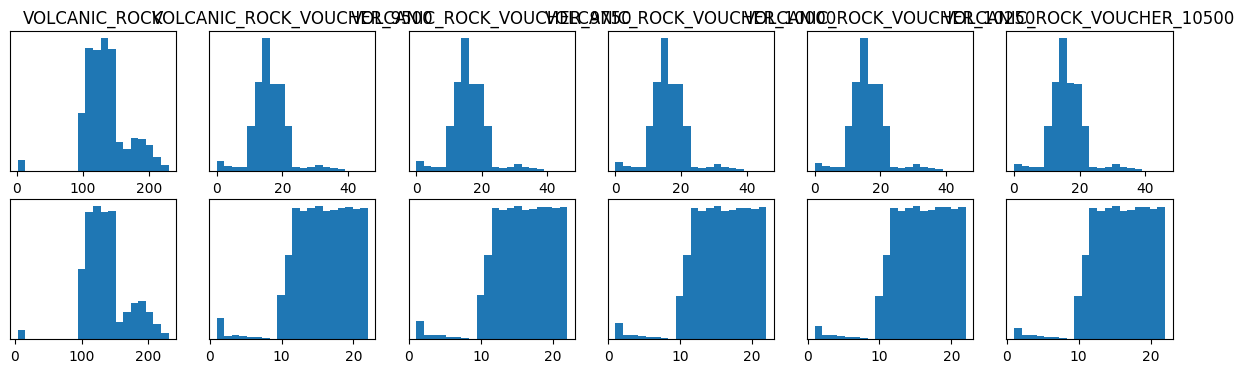

In [25]:
fig, ax = plt.subplots(2, 6, figsize=(15, 4))
for i, prod in enumerate(products):
    ax[0, i].hist(prod['bid_volume_1'], bins=20)
    ax[1, i].hist(prod['ask_volume_1'], bins=20)
    ax[0, i].set_title(prod.iloc[0]['product'])
    ax[0, i].set_yticks([])
    ax[1, i].set_yticks([])
plt.show()

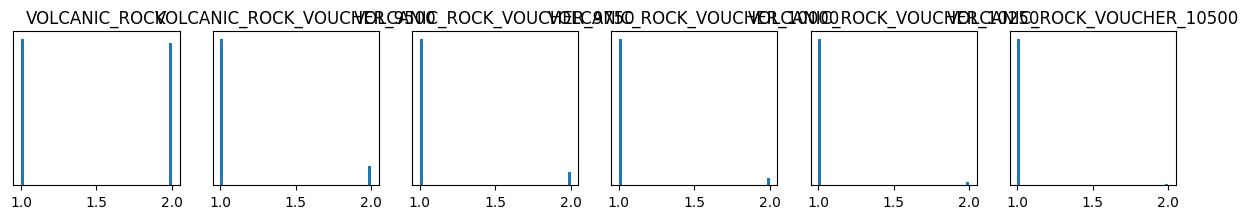

In [27]:
fig, ax = plt.subplots(1, 6, figsize=(15, 2))
for i, prod in enumerate(products):
    ax[i].hist(prod['ask_price_1'] - prod['bid_price_1'], bins=50)
    ax[i].set_title(prod.iloc[0]['product'])
    ax[i].set_yticks([])
plt.show()

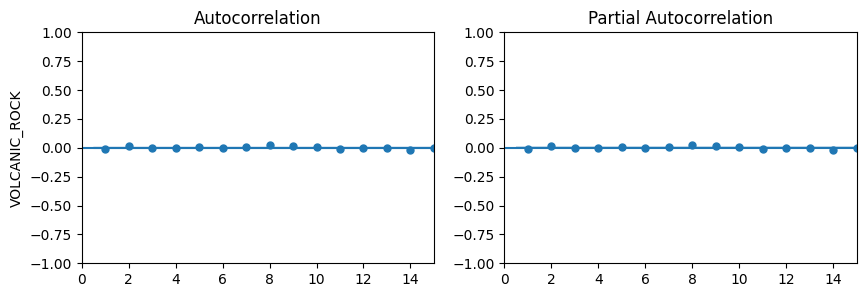

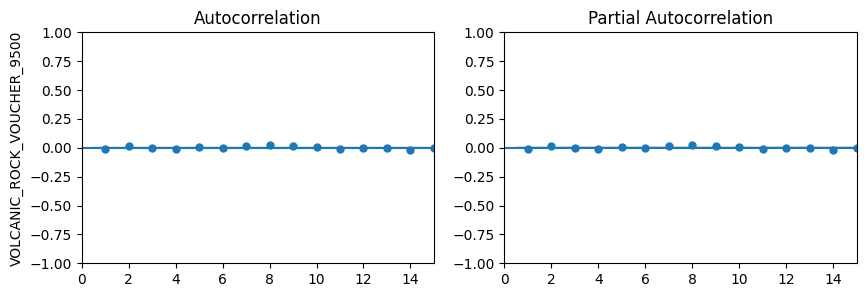

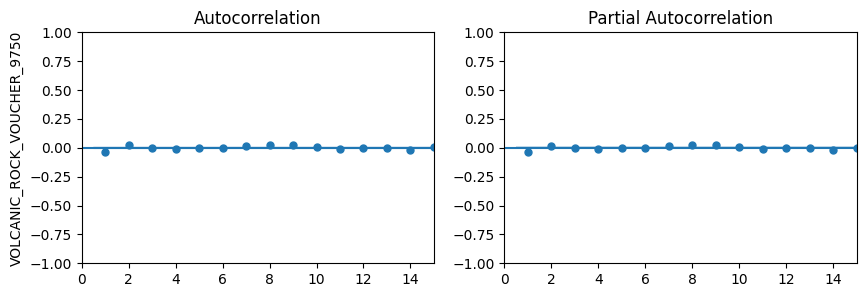

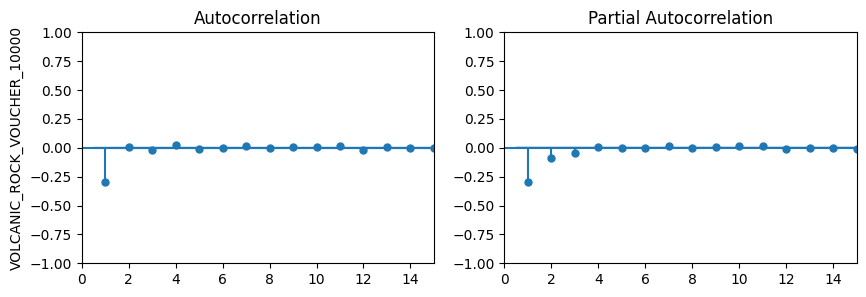

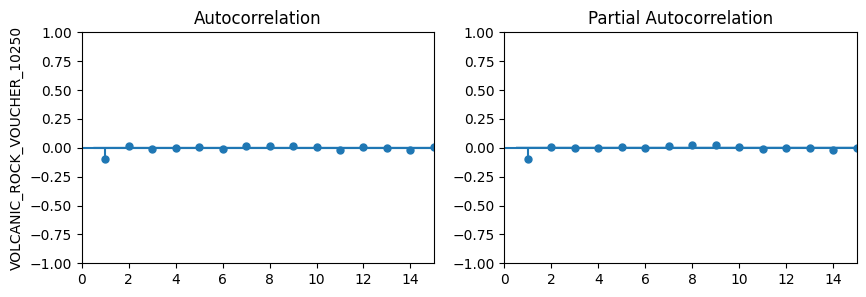

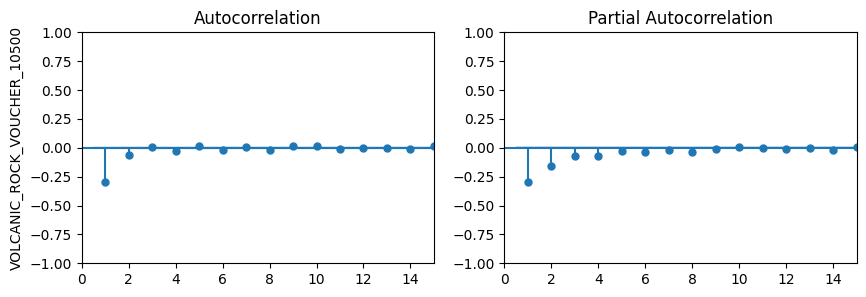

In [41]:
for prod in products:
    logr = np.log(prod['mid_price']) - np.log(prod['mid_price'].shift(1))
    logr = logr.dropna()
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    plot_acf(logr, ax=ax[0], zero=False)
    plot_pacf(logr, ax=ax[1], zero=False)
    ax[0].set_xlim([0, 15])
    ax[1].set_xlim([0, 15])
    ax[0].set_ylabel(prod.iloc[0]['product'])
    plt.show()